In [3]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.optimize import minimize
import statsmodels.api as sm
import scipy.stats as stats
from skpp import ProjectionPursuitRegressor
from sklearn.linear_model import LassoCV
from collections import Counter

ModuleNotFoundError: No module named 'skpp'

In [4]:
import os
curr_path = os.getcwd()
citibike_path = os.path.join(curr_path, "citibike_day.csv")
weather_path = os.path.join(curr_path, "nyc_Weather_2013_2023.csv")

In [5]:
# Load data
citibike_df = pd.read_csv(citibike_path)
weather_df = pd.read_csv(weather_path)

In [6]:
# Display basic information
citibike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      365 non-null    int64  
 1   date            365 non-null    object 
 2   num_trips       365 non-null    int64  
 3   avg_duration    365 non-null    float64
 4   total_duration  365 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 14.4+ KB


In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time                        4017 non-null   object 
 1   temperature_2m_max          4017 non-null   float64
 2   temperature_2m_min          4017 non-null   float64
 3   apparent_temperature_max    4017 non-null   float64
 4   apparent_temperature_min    4017 non-null   float64
 5   precipitation_sum           4017 non-null   float64
 6   rain_sum                    4017 non-null   float64
 7   snowfall_sum                4017 non-null   float64
 8   precipitation_hours         4017 non-null   float64
 9   sunshine_duration           4017 non-null   float64
 10  windspeed_10m_max           4017 non-null   float64
 11  windgusts_10m_max           4017 non-null   float64
 12  winddirection_10m_dominant  4017 non-null   int64  
 13  shortwave_radiation_sum     4017 

In [8]:
# Compute average daily temperature
weather_df['temperature_avg'] = (weather_df['temperature_2m_max'] + weather_df['temperature_2m_min']) / 2

In [9]:
# Rename 'time' to 'date' and convert to datetime
weather_df = weather_df.rename(columns={'time': 'date'})
weather_df['date'] = pd.to_datetime(weather_df['date'])
citibike_df['date'] = pd.to_datetime(citibike_df['date'])

In [10]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        4017 non-null   datetime64[ns]
 1   temperature_2m_max          4017 non-null   float64       
 2   temperature_2m_min          4017 non-null   float64       
 3   apparent_temperature_max    4017 non-null   float64       
 4   apparent_temperature_min    4017 non-null   float64       
 5   precipitation_sum           4017 non-null   float64       
 6   rain_sum                    4017 non-null   float64       
 7   snowfall_sum                4017 non-null   float64       
 8   precipitation_hours         4017 non-null   float64       
 9   sunshine_duration           4017 non-null   float64       
 10  windspeed_10m_max           4017 non-null   float64       
 11  windgusts_10m_max           4017 non-null   float64     

In [11]:
# Select and rename relevant columns
weather_selected = weather_df[[
    'date',
    'temperature_avg',
    'precipitation_sum',
    'windspeed_10m_max',
    'sunshine_duration'
]]

In [12]:
# Merge with Citi Bike data
merged_df = pd.merge(citibike_df, weather_selected, on='date', how='inner').dropna()

In [13]:
# Display first few rows of the merged dataset
merged_df.head()

,Unnamed: 0,date,num_trips,avg_duration,total_duration,temperature_avg,precipitation_sum,windspeed_10m_max,sunshine_duration
0,0,2015-01-01,5317,801.806658,4263206,-1.00,0.0,21.3,29236.59
1,1,2015-01-02,11304,731.240977,8265948,1.45,0.0,19.9,29150.96
2,2,2015-01-03,4478,655.284279,2934363,1.75,16.5,15.8,6444.89
3,3,2015-01-04,7849,679.554211,5333821,10.00,7.2,22.3,0.00
4,4,2015-01-05,14506,637.811802,9252098,1.55,0.0,26.8,29161.29


In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         365 non-null    int64         
 1   date               365 non-null    datetime64[ns]
 2   num_trips          365 non-null    int64         
 3   avg_duration       365 non-null    float64       
 4   total_duration     365 non-null    int64         
 5   temperature_avg    365 non-null    float64       
 6   precipitation_sum  365 non-null    float64       
 7   windspeed_10m_max  365 non-null    float64       
 8   sunshine_duration  365 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 25.8 KB


# Regression Analysis

In [15]:
# Define response and predictors
X = merged_df[['temperature_avg', 'precipitation_sum', 'windspeed_10m_max', 'sunshine_duration']]
y = merged_df['num_trips']

In [16]:
# Add constant to predictors
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

In [17]:
# Show regression summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_trips   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     197.9
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.59e-89
Time:                        13:39:26   Log-Likelihood:                -3775.7
No. Observations:                 365   AIC:                             7561.
Df Residuals:                     360   BIC:                             7581.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.186e+04   1778.374     12.290      0.000    1.84e+04    2.54e+04
temperature_avg     950.7864     42.906     22.160      0.000     866.409    1035.164
precipitation_sum  -554.2002     72.091     -7.688      0.000    -695.972    -412.428
windspeed_10m_max  -266.0749     81.373     -3.270      0.001    -426.102    -106.048
sunshine_duration    -0.0039      0.034     -0.114      0.909      -0.070       0.062
==============================================================================
Omnibus:                       13.958   Durbin-Watson:                   0.629
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.860
Skew:                           0.494   Prob(JB):                     0.000593
Kurtosis:                       2.989   Cond. No.                     1.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Visualization

In [18]:
# Predict values using the fitted model
merged_df['predicted_trips'] = model.predict(X)

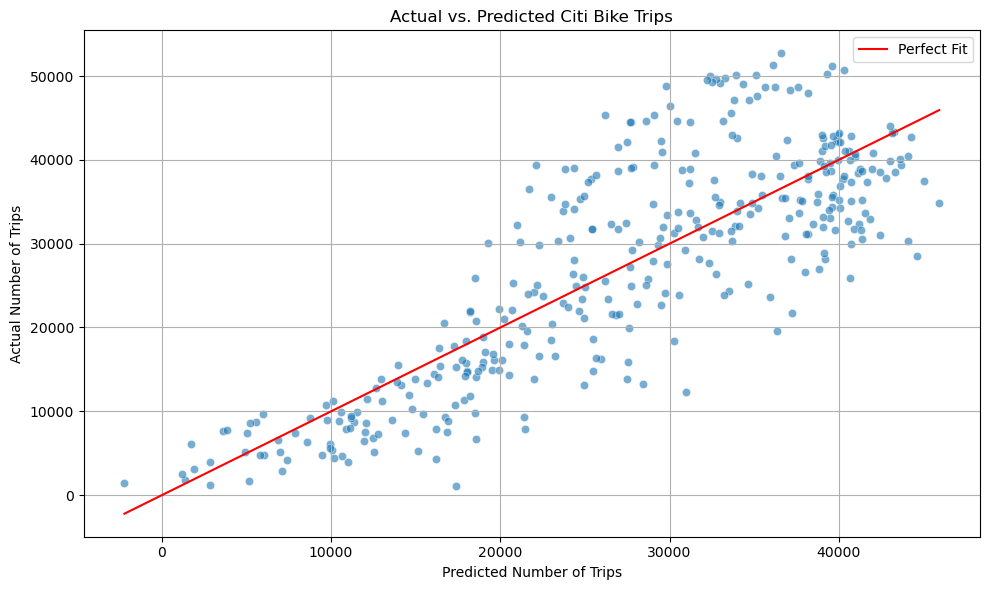

In [19]:
# Create a new DataFrame just for plotting
plot_df = merged_df[['num_trips', 'predicted_trips']].copy()

# Plot actual vs. predicted values with a perfect fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='predicted_trips', y='num_trips', alpha=0.6)
sns.lineplot(data=plot_df.sort_values('predicted_trips'), x='predicted_trips', y='predicted_trips', color='red', label='Perfect Fit')
plt.title('Actual vs. Predicted Citi Bike Trips')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Actual Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Calculate residuals
merged_df['residuals'] = merged_df['num_trips'] - merged_df['predicted_trips']

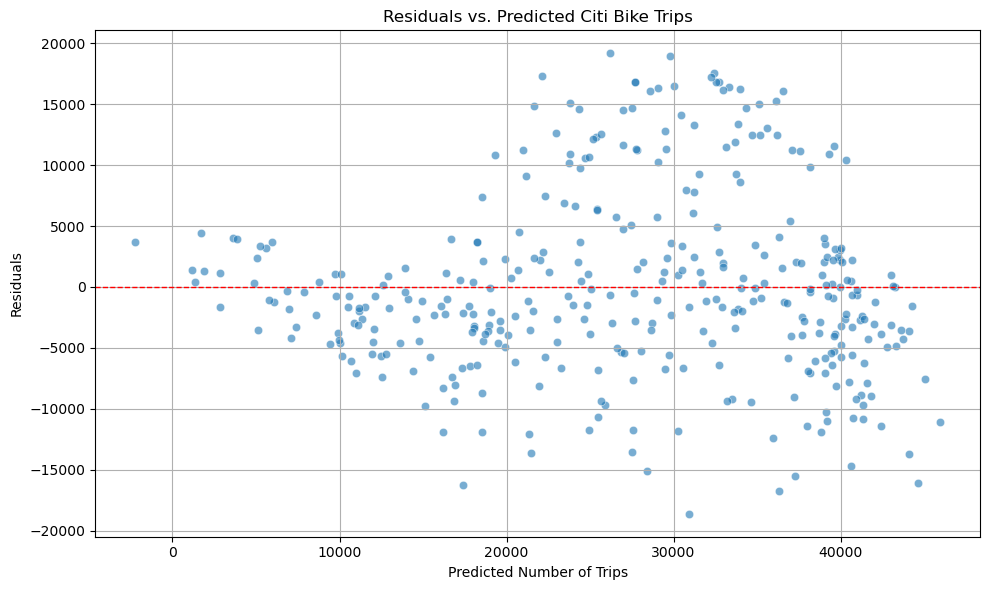

In [21]:
# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predicted_trips', y='residuals', data=merged_df, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted Citi Bike Trips')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

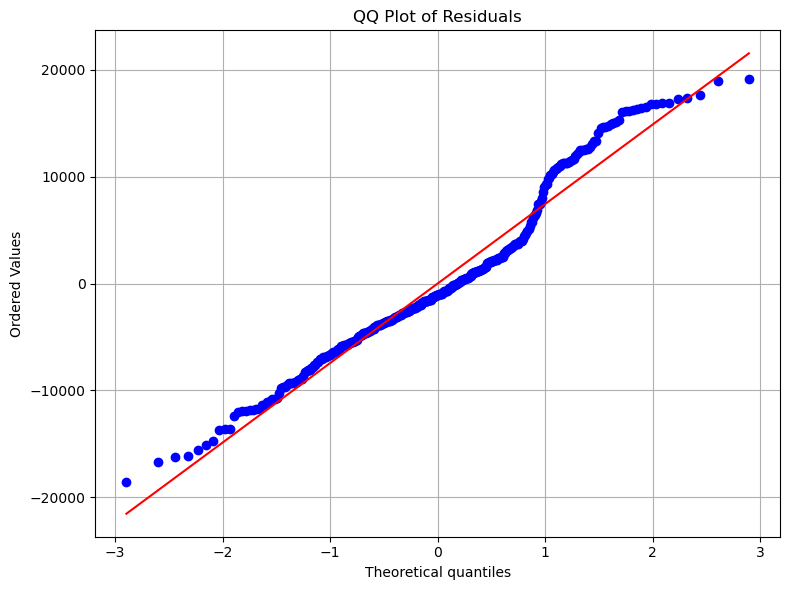

In [22]:
# Generate QQ plot of residuals
plt.figure(figsize=(8, 6))
stats.probplot(merged_df['residuals'], dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Log-transforming

In [23]:
# Add log-transformed features
merged_df['log_num_trips'] = np.log1p(merged_df['num_trips'])  # log(1 + trips)
merged_df['log_temperature_avg'] = np.log1p(merged_df['temperature_avg'] - merged_df['temperature_avg'].min() + 1)
merged_df['log_precipitation_sum'] = np.log1p(merged_df['precipitation_sum'])
merged_df['log_windspeed_10m_max'] = np.log1p(merged_df['windspeed_10m_max'])
merged_df['log_sunshine_duration'] = np.log1p(merged_df['sunshine_duration'])

In [24]:
# Define new model predictors and response
X_log = merged_df[['log_temperature_avg', 'log_precipitation_sum', 'log_windspeed_10m_max', 'log_sunshine_duration']]
y_log = merged_df['log_num_trips']
X_log = sm.add_constant(X_log)

# Fit the log-transformed model
model_log = sm.OLS(y_log, X_log).fit()

# Show summary of the log-transformed model
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_num_trips   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     248.5
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          3.63e-102
Time:                        13:39:30   Log-Likelihood:                -162.49
No. Observations:                 365   AIC:                             335.0
Df Residuals:                     360   BIC:                             354.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.7365      0.272     24.805      0.000       6.202       7.271
log_temperature_avg       1.0576      0.039     27.011      0.000       0.981       1.135
log_precipitation_sum    -0.1957      0.024     -8.024      0.000      -0.244      -0.148
log_windspeed_10m_max    -0.1194      0.072     -1.666      0.097      -0.260       0.022
log_sunshine_duration     0.0330      0.009      3.794      0.000       0.016       0.050
==============================================================================
Omnibus:                      137.200   Durbin-Watson:                   1.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1162.070
Skew:                          -1.334   Prob(JB):                    4.57e-253
Kurtosis:                      11.324   Cond. No.                         151.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualization

In [25]:
# Predict log(num_trips) and back-transform to original scale
merged_df['log_predicted_trips'] = model_log.predict(X_log)
merged_df['backtransformed_predicted_trips'] = np.expm1(merged_df['log_predicted_trips'])

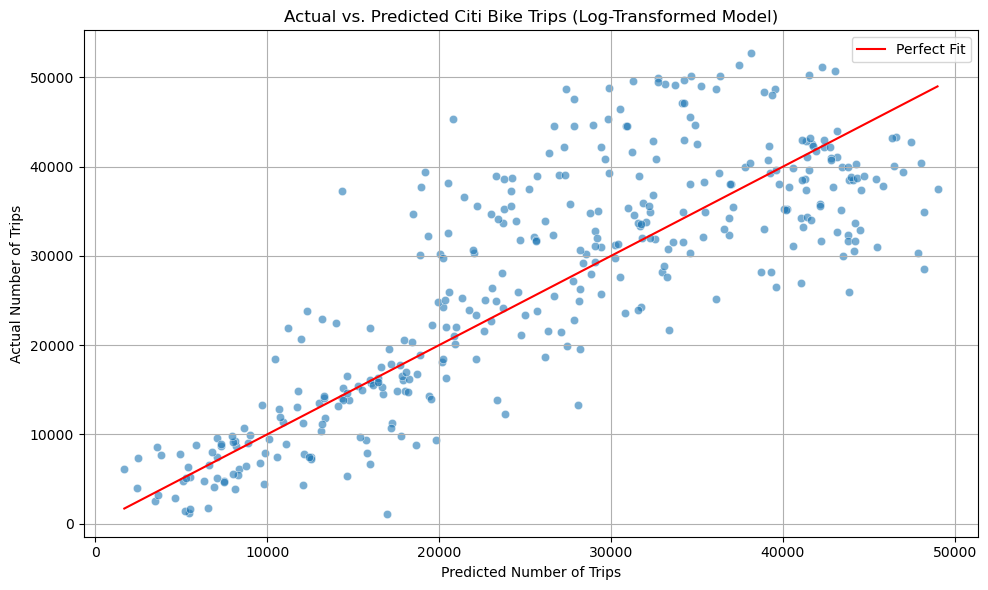

In [26]:
# Plot actual vs. predicted (original scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='backtransformed_predicted_trips',
    y='num_trips',
    data=merged_df,
    alpha=0.6
)
sns.lineplot(
    x='backtransformed_predicted_trips',
    y='backtransformed_predicted_trips',
    data=merged_df.sort_values('backtransformed_predicted_trips'),
    color='red',
    label='Perfect Fit'
)
plt.title('Actual vs. Predicted Citi Bike Trips (Log-Transformed Model)')
plt.xlabel('Predicted Number of Trips')
plt.ylabel('Actual Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Calculate residuals in log scale
merged_df['log_residuals'] = merged_df['log_num_trips'] - merged_df['log_predicted_trips']

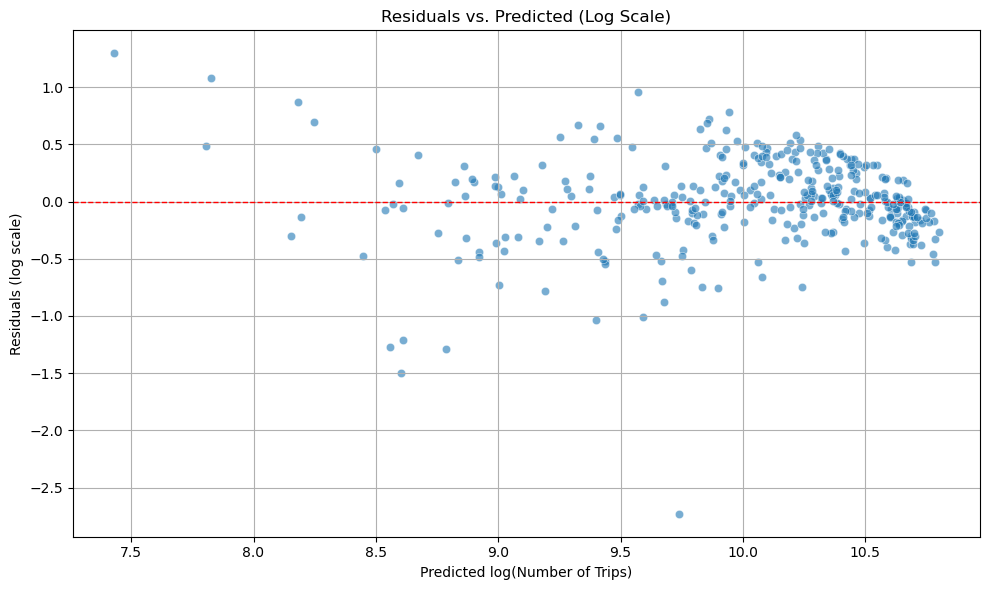

In [28]:
# Residual plot: log residuals vs. predicted (log scale)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='log_predicted_trips',
    y='log_residuals',
    data=merged_df,
    alpha=0.6
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted (Log Scale)')
plt.xlabel('Predicted log(Number of Trips)')
plt.ylabel('Residuals (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

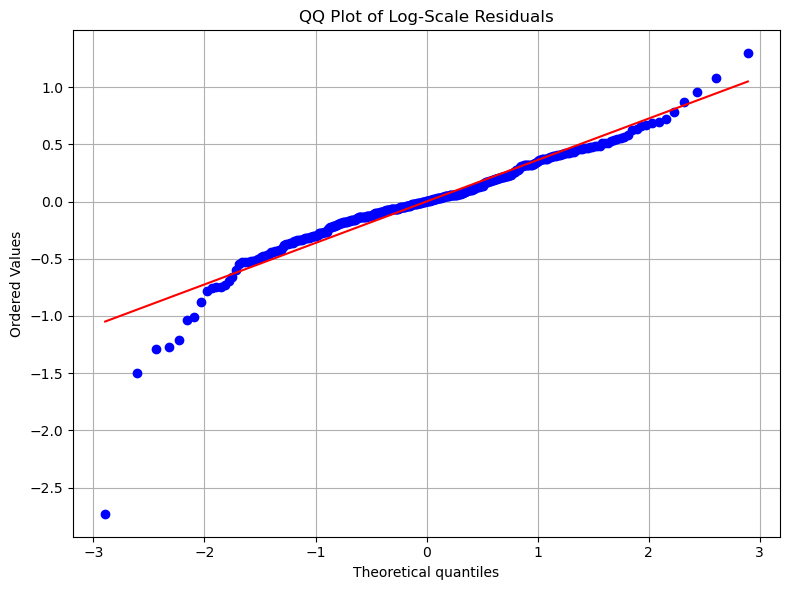

In [29]:
# QQ plot for log residuals
plt.figure(figsize=(8, 6))
stats.probplot(merged_df['log_residuals'], dist="norm", plot=plt)
plt.title('QQ Plot of Log-Scale Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Partial Least Squares Regression

In [30]:
merged_df_pp = pd.merge(citibike_df, weather_df, on='date', how='inner').dropna()

In [31]:
features = [
    'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'sunshine_duration', 'windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant',
    'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'temperature_avg'
]
X = merged_df_pp[features]
y = merged_df_pp['num_trips']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state= 42)

In [32]:
pls = PLSRegression(n_components=5)
pls.fit(X_train_scaled, y_train)

y_pred = pls.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 6759.398624717034
R²: 0.745126140393312


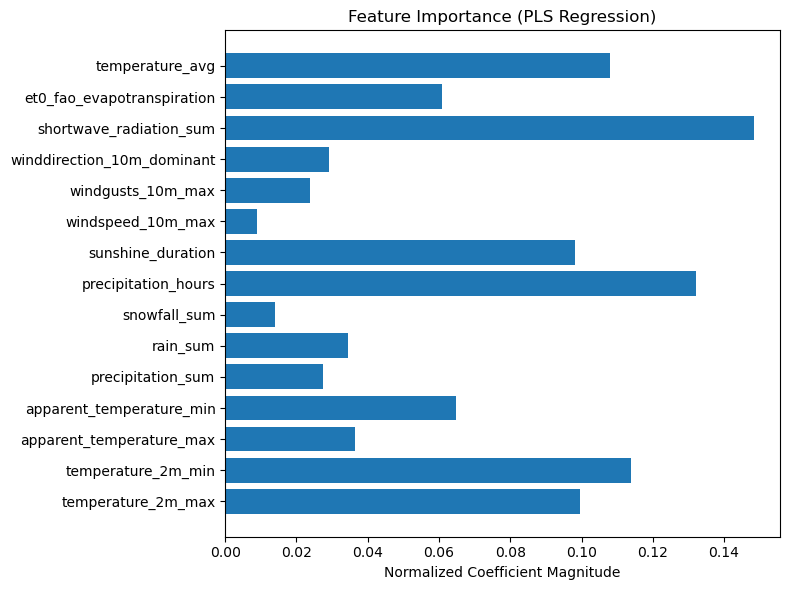

In [33]:
coeffs = np.abs(pls.coef_).flatten()
coeffs /= np.sum(coeffs)

plt.figure(figsize=(8, 6))
plt.barh(X.columns, coeffs)
plt.xlabel("Normalized Coefficient Magnitude")
plt.title("Feature Importance (PLS Regression)")
plt.tight_layout()
plt.show()


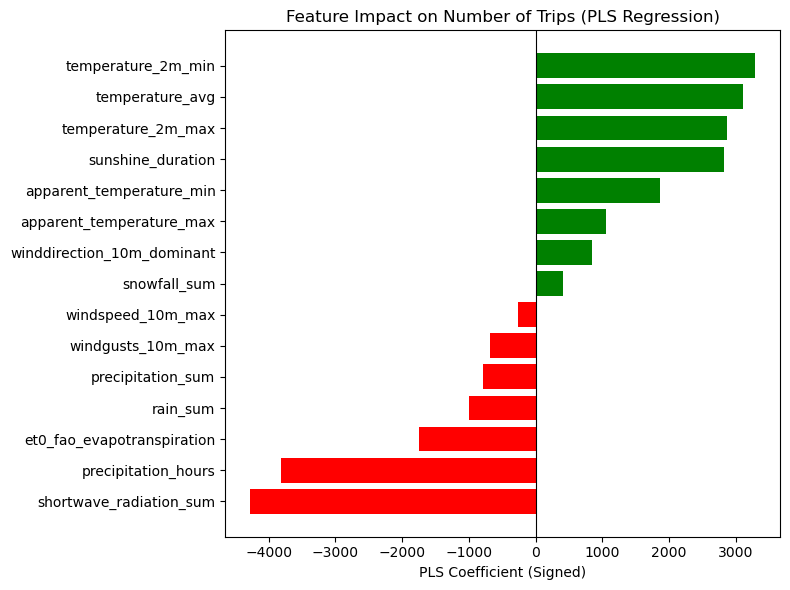

In [34]:
coeffs_signed = pls.coef_.flatten()
impact_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coeffs_signed
}).sort_values(by='Coefficient', ascending=True) 

plt.figure(figsize=(8, 6))
bars = plt.barh(impact_df['Feature'], impact_df['Coefficient'],
                color=['green' if c > 0 else 'red' for c in impact_df['Coefficient']])
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel("PLS Coefficient (Signed)")
plt.title("Feature Impact on Number of Trips (PLS Regression)")
plt.tight_layout()
plt.show()

Temperature ANOVA: F_onewayResult(statistic=248.93908429347974, pvalue=9.843923705640121e-69)
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
  Cold    Hot  28598.0609   0.0  25560.4613 31635.6605   True
  Cold   Mild  17507.4512   0.0  14447.9848 20566.9176   True
   Hot   Mild -11090.6097   0.0 -13476.9897 -8704.2297   True
-------------------------------------------------------------


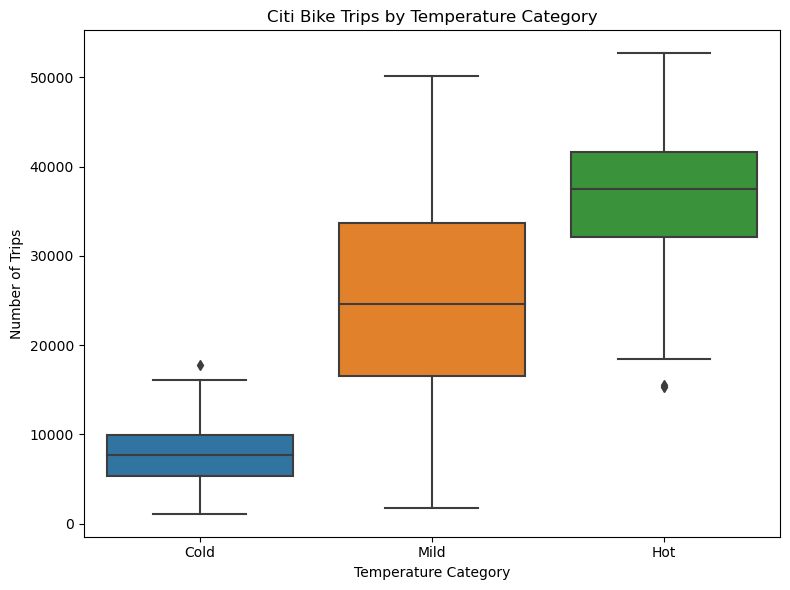

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load data
weather_df = pd.read_csv("nyc_weather_2013_2023.csv")
bike_df = pd.read_csv("citibike_day.csv")

# Convert date columns
weather_df["time"] = pd.to_datetime(weather_df["time"])
bike_df["date"] = pd.to_datetime(bike_df["date"])

# Merge
merged_df = pd.merge(bike_df, weather_df, left_on="date", right_on="time")

# Temperature category
def categorize_temp(temp):
    if temp < 5:
        return "Cold"
    elif 5 <= temp <= 20:
        return "Mild"
    else:
        return "Hot"

merged_df["temp_category"] = merged_df["temperature_2m_max"].apply(categorize_temp)

# ANOVA
temp_groups = merged_df.groupby("temp_category")["num_trips"].apply(list)
temp_anova = f_oneway(*temp_groups)
print("Temperature ANOVA:", temp_anova)

# Tukey HSD for Temperature
tukey_temp = pairwise_tukeyhsd(
    endog=merged_df["num_trips"],
    groups=merged_df["temp_category"],
    alpha=0.05
)
print(tukey_result)

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="temp_category", y="num_trips", data=merged_df)
plt.title("Citi Bike Trips by Temperature Category")
plt.xlabel("Temperature Category")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

Precipitation ANOVA: F_onewayResult(statistic=15.62696766833985, pvalue=3.093315843297417e-07)
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff  p-adj    lower     upper    reject
-------------------------------------------------------------------
Heavy Rain Light Rain  6250.2382 0.0125 1101.9523 11398.5242   True
Heavy Rain    No Rain 10601.1689    0.0 5987.9472 15214.3906   True
Light Rain    No Rain  4350.9307 0.0176  614.8757  8086.9856   True
-------------------------------------------------------------------


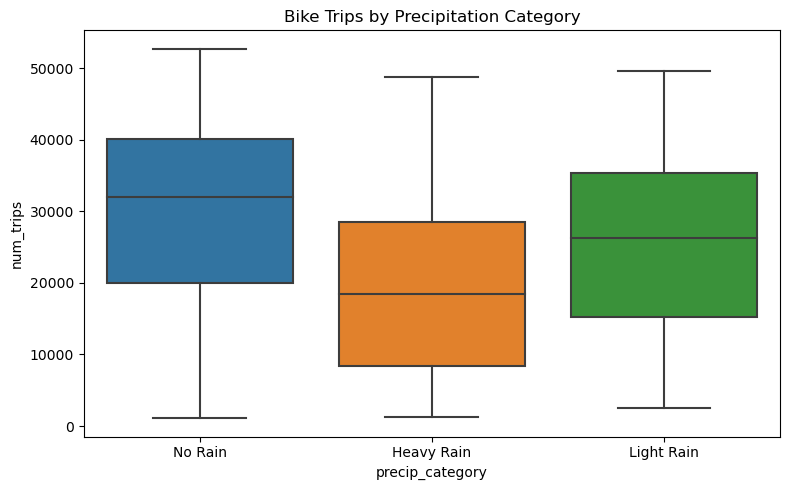

In [38]:
# Precipitation category
def categorize_precip(p):
    if p == 0:
        return "No Rain"
    elif p <= 5:
        return "Light Rain"
    else:
        return "Heavy Rain"

merged_df["precip_category"] = merged_df["precipitation_sum"].apply(categorize_precip)

# ANOVA for Precipitation 
precip_groups = merged_df.groupby("precip_category")["num_trips"].apply(list)
precip_anova = f_oneway(*precip_groups)
print("Precipitation ANOVA:", precip_anova)

# Tukey HSD for Precipitation
tukey_precip = pairwise_tukeyhsd(
    endog=merged_df["num_trips"],
    groups=merged_df["precip_category"],
    alpha=0.05
)
print(tukey_precip)

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="precip_category", y="num_trips", data=merged_df)
plt.title("Bike Trips by Precipitation Category")
plt.tight_layout()
plt.show()

Sunshine Duration ANOVA: F_onewayResult(statistic=25.782967460505027, pvalue=3.401338631787172e-11)
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
    group1          group2       meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------------------------
High Sunshine      Low Sunshine -12750.547    0.0 -17123.4046 -8377.6893   True
High Sunshine Moderate Sunshine -6559.2737 0.0049 -11447.7829 -1670.7646   True
 Low Sunshine Moderate Sunshine  6191.2733 0.0427    160.6584 12221.8881   True
-------------------------------------------------------------------------------


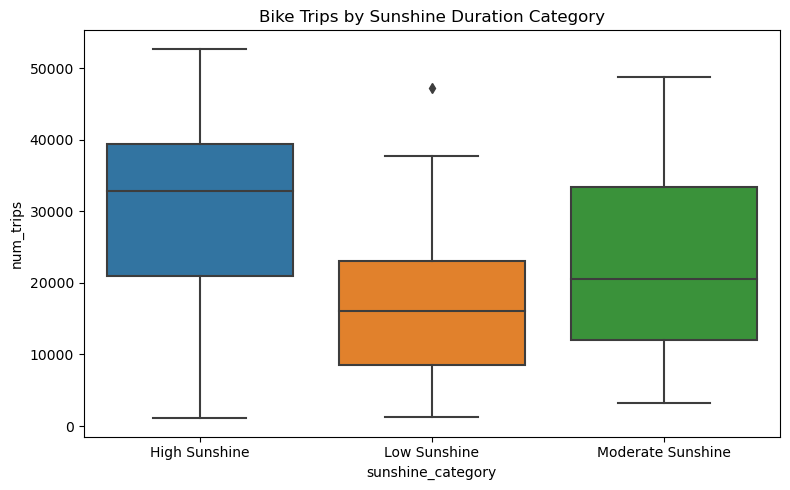

In [39]:
# Sunshine Duration category
def categorize_sunshine(sun):
    if sun < 10000:
        return "Low Sunshine"
    elif 10000 <= sun < 25000:
        return "Moderate Sunshine"
    else:
        return "High Sunshine"

merged_df["sunshine_category"] = merged_df["sunshine_duration"].apply(categorize_sunshine)

# ANOVA for Sunshine
sunshine_groups = merged_df.groupby("sunshine_category")["num_trips"].apply(list)
sunshine_anova = f_oneway(*sunshine_groups)
print("Sunshine Duration ANOVA:", sunshine_anova)


# Tukey HSD for Sunshine Duration
tukey_sun = pairwise_tukeyhsd(
    endog=merged_df["num_trips"],
    groups=merged_df["sunshine_category"],
    alpha=0.05
)
print(tukey_sun)

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="sunshine_category", y="num_trips", data=merged_df)
plt.title("Bike Trips by Sunshine Duration Category")
plt.tight_layout()
plt.show()